In [1]:
import xarray as xr

import pycomlink as pycml

/Users/chwala-c/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/pycomlink/io/examples.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# Load data
data_path = pycml.io.examples.get_example_data_path()
cmls = xr.open_dataset(data_path + '/example_cml_data.nc')

# select 3 different CMLs to study
cmls = cmls.isel(cml_id = [0, 10, 370])

# Remove outliers, compute tl and interpolate missing values
cmls['tsl'] = cmls.tsl.where(cmls.tsl != 255.0)
cmls['rsl'] = cmls.rsl.where(cmls.rsl != -99.9)
cmls['tl'] = cmls.tsl - cmls.rsl # calculate total loss (previous TRSL)
cmls['tl'] = cmls.tl.interpolate_na(dim='time', method='linear', max_gap='5min')

In [3]:
import sys
sys.path.append('../pycomlink/processing/wet_dry/cml_wd_pytorch/src')

In [4]:
import cml_wd_pytorch

In [5]:
from cml_wd_pytorch.inference import run_inference

In [6]:
run_inference.test_cnn_wd()

INFO:root:Final dataset variables: ['TL', 'predictions']
INFO:root:Final dataset dimensions: FrozenMappingWarningOnValuesAccess({'time': 1000, 'channels': 2, 'cml_id': 5})
INFO:root:Predictions shape: (1000, 5)
INFO:root:Predictions dimensions: ('time', 'cml_id')
INFO:root:Sample predictions:
[[0.00023332 0.00023791 0.00023377]
 [0.0002429  0.00024283 0.0002282 ]
 [0.00022297 0.00023624 0.00023122]
 [0.00023335 0.00023809 0.00023462]
 [0.00024357 0.00024076 0.00022987]]


In [7]:
#model_path = '/Users/chwala-c/code/pycomlink/pycomlink/processing/wet_dry/cml_wd_pytorch/data/dummy_model/model_epoch_0.pth'
model_path = '/Users/chwala-c/code/pycomlink/pycomlink/processing/wet_dry/cml_wd_pytorch/data/dummy_model/model_epoch_15.pth'

In [8]:
# Dataarray shape is expected to be (time, channels, cml_id).
cmls.tl.transpose('time', 'channel_id', 'cml_id')

<xarray.DataArray 'tl' (time: 15840, channel_id: 2, cml_id: 3)> Size: 760kB
array([[[60. , 53.9, 72.4],
        [55.7, 55.1, 61.1]],

       [[59. , 53.9, 72.4],
        [55.7, 55.1, 61.1]],

       [[58.7, 53.9, 72.4],
        [56. , 55.1, 61.1]],

       ...,

       [[59. , 54.5, 57. ],
        [57. , 55.5, 60.2]],

       [[58.7, 54.2, 57. ],
        [56.7, 55.5, 60.2]],

       [[58.7, 54.5, 57. ],
        [57. , 55.5, 60.2]]], shape=(15840, 2, 3))
Coordinates:
  * time              (time) datetime64[ns] 127kB 2018-05-10 ... 2018-05-20T2...
  * cml_id            (cml_id) <U3 36B '0' '10' '370'
    length            (cml_id) float64 24B 6.179 2.862 5.721
    site_a_latitude   (cml_id) float64 24B 58.26 58.05 57.89
    site_a_longitude  (cml_id) float64 24B 1.388 1.34 1.292
    site_b_latitude   (cml_id) float64 24B 58.25 58.04 57.83
    site_b_longitude  (cml_id) float64 24B 1.304 1.378 1.298
  * channel_id        (channel_id) <U9 72B 'channel_1' 'channel_2'
    frequency         (channel_id, cml_id) float64 48B 2.491e+10 ... 2.486e+10
    polarization      (channel_id, cml_id) <U1 24B 'V' 'V' 'V' 'V' 'V' 'V'

In [14]:
tl = cmls.tl.transpose('time', 'channel_id', 'cml_id')
tl_normed = tl - tl.median(dim='time')

In [16]:
# cmls['cml_id'] = range(len(cmls['cml_id']))
# cmls['time'] = range(len(cmls['time']))

result = run_inference.cnn_wd(model_path=model_path, data=tl)

In [10]:
result

<xarray.Dataset> Size: 1MB
Dimensions:           (time: 15840, cml_id: 3, channel_id: 2)
Coordinates:
  * time              (time) datetime64[ns] 127kB 2018-05-10 ... 2018-05-20T2...
  * cml_id            (cml_id) <U3 36B '0' '10' '370'
    length            (cml_id) float64 24B 6.179 2.862 5.721
    site_a_latitude   (cml_id) float64 24B 58.26 58.05 57.89
    site_a_longitude  (cml_id) float64 24B 1.388 1.34 1.292
    site_b_latitude   (cml_id) float64 24B 58.25 58.04 57.83
    site_b_longitude  (cml_id) float64 24B 1.304 1.378 1.298
  * channel_id        (channel_id) <U9 72B 'channel_1' 'channel_2'
    frequency         (channel_id, cml_id) float64 48B 2.491e+10 ... 2.486e+10
    polarization      (channel_id, cml_id) <U1 24B 'V' 'V' 'V' 'V' 'V' 'V'
Data variables:
    TL                (time, channel_id, cml_id) float64 760kB 60.0 ... 60.2
    predictions       (time, cml_id) float64 380kB 0.9892 0.983 ... nan nan

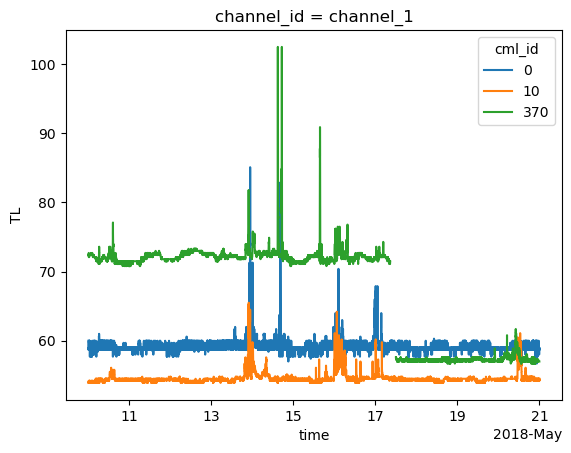

In [11]:
result.TL.isel(channel_id=0).plot.line(x='time');

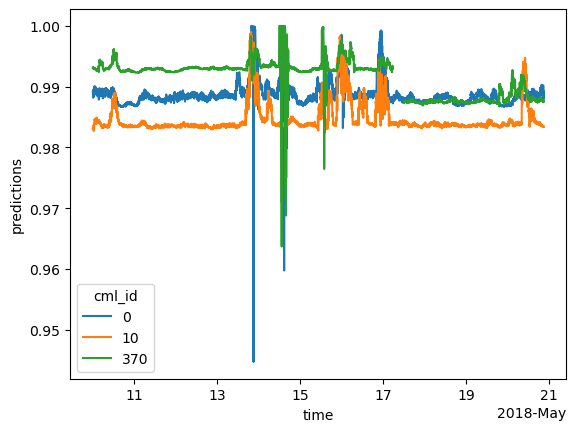

In [12]:
result.predictions.plot.line(x='time');